In [1]:
!pip install transformers accelerate datasets tokenizers seqeval -q


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 40.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00


In [ ]:
! pip install spacy


In [2]:
from datasets import Dataset, ClassLabel, Sequence, load_dataset, load_metric
import numpy as np
import pandas as pd
from spacy import displacy
import transformers
from transformers import (AutoModelForTokenClassification,
                          AutoTokenizer,
                          DataCollatorForTokenClassification,
                          pipeline,
                          TrainingArguments,
                          Trainer)

In [ ]:
# confirm version > 4.11.0
print(transformers.__version__)

4.32.1


In [3]:
#dataset ADE-corpus-v2
#https://huggingface.co/datasets/ade_corpus_v2
datasets = load_dataset("ade_corpus_v2", "Ade_corpus_v2_drug_ade_relation")
datasets

Generating train split:   0%|          | 0/6821 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'drug', 'effect', 'indexes'],
        num_rows: 6821
    })
})

In [4]:
datasets["train"][0]
# datasets["train"].shape


{'text': 'Intravenous azithromycin-induced ototoxicity.',
 'drug': 'azithromycin',
 'effect': 'ototoxicity',
 'indexes': {'drug': {'start_char': [12], 'end_char': [24]},
  'effect': {'start_char': [33], 'end_char': [44]}}}

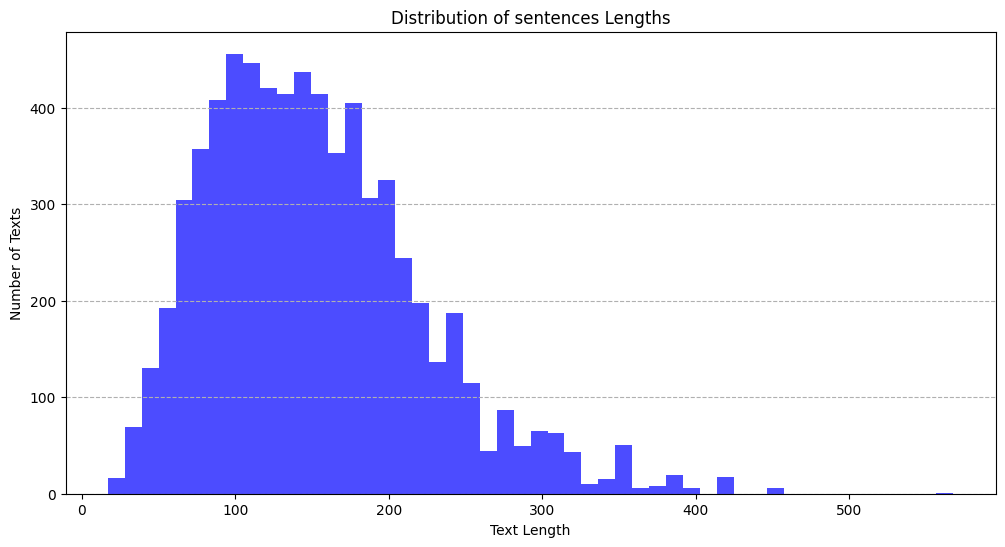

In [5]:
#draw the distribution of the text length
import matplotlib.pyplot as plt

# Assuming you have a list of texts like this:
texts = datasets["train"]['text']

# Calculate lengths of each text
text_lengths = [len(text) for text in texts]

# Plotting the histogram
plt.figure(figsize=(12, 6))
plt.hist(text_lengths, bins=50, color='blue', alpha=0.7)  # You can adjust the number of bins as needed
plt.title('Distribution of sentences Lengths')
plt.xlabel('Text Length')
plt.ylabel('Number of Texts')
plt.grid(axis='y', linestyle='--')
plt.show()


In [6]:
consolidated_dataset = {}

for row in datasets["train"]:
    if row["text"] in consolidated_dataset:
        # consolidated_dataset[row["text"]]["drug_indices_start"].update(row["indexes"]["drug"]["start_char"])
        # consolidated_dataset[row["text"]]["drug_indices_end"].update(row["indexes"]["drug"]["end_char"])
        consolidated_dataset[row["text"]]["effect_indices_start"].update(row["indexes"]["effect"]["start_char"])
        consolidated_dataset[row["text"]]["effect_indices_end"].update(row["indexes"]["effect"]["end_char"])
        # consolidated_dataset[row["text"]]["drug"].append(row["drug"])
        consolidated_dataset[row["text"]]["effect"].append(row["effect"])

    else:
        consolidated_dataset[row["text"]] = {
            "text": row["text"],
            # "drug": [row["drug"]],
            "effect": [row["effect"]],
            # use sets because the indices can repeat for various reasons
            # "drug_indices_start": set(row["indexes"]["drug"]["start_char"]),
            # "drug_indices_end": set(row["indexes"]["drug"]["end_char"]),
            "effect_indices_start": set(row["indexes"]["effect"]["start_char"]),
            "effect_indices_end": set(row["indexes"]["effect"]["end_char"])
        }

df = pd.DataFrame(list(consolidated_dataset.values()))


In [7]:
df.shape

(4271, 4)

In [8]:
df.head()


,text,effect,effect_indices_start,effect_indices_end
0,Intravenous azithromycin-induced ototoxicity.,[ototoxicity],{33},{44}
1,"Immobilization, while Paget's bone disease was...",[increased calcium-release],{143},{168}
2,Unaccountable severe hypercalcemia in a patien...,[hypercalcemia],{21},{34}
3,METHODS: We report two cases of pseudoporphyri...,"[pseudoporphyria, pseudoporphyria]",{32},{47}
4,"Naproxen, the most common offender, has been a...",[erythropoietic protoporphyria],{134},{163}


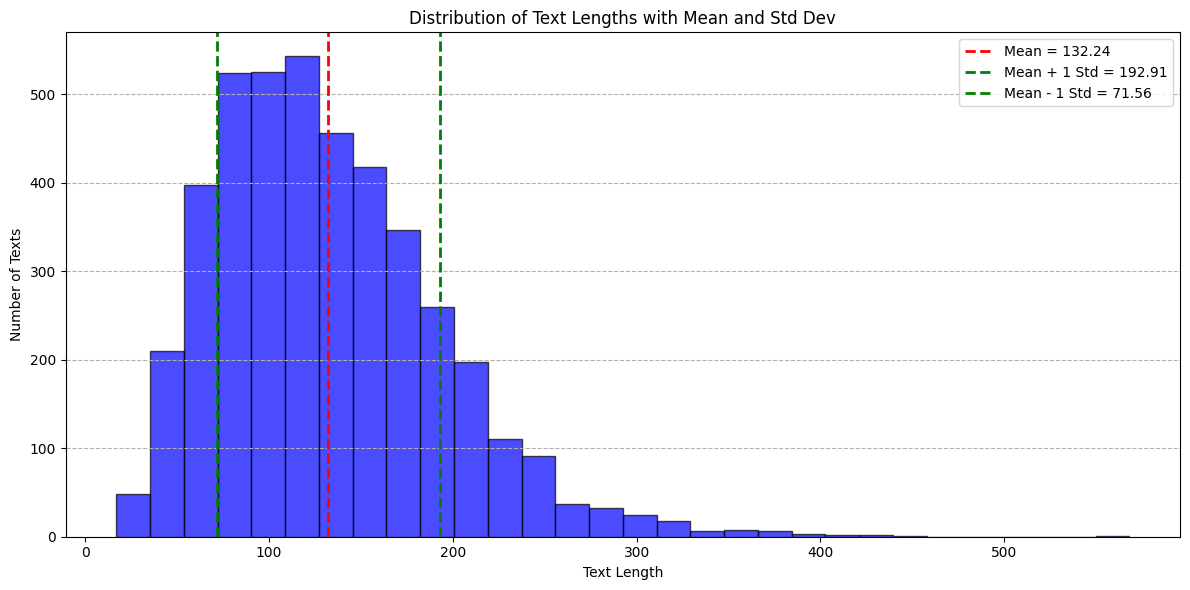

In [9]:
#after merge the repreated sentences, plot each sentences word length distribution.
#draw the distribution of the text length
import matplotlib.pyplot as plt

# Assuming you have a list of texts like this:
texts = df['text']

# Calculate lengths of each text
text_lengths = [len(text) for text in texts]

# Compute statistical measures
mean_length = np.mean(text_lengths)
std_length = np.std(text_lengths)

# Plotting the histogram
plt.figure(figsize=(12, 6))
plt.hist(text_lengths, bins=30, color='blue', alpha=0.7, edgecolor='black')  # You can adjust the number of bins as needed

# Adding vertical lines for mean and standard deviation
plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=2, label=f'Mean = {mean_length:.2f}')
plt.axvline(mean_length + std_length, color='g', linestyle='dashed', linewidth=2, label=f'Mean + 1 Std = {mean_length + std_length:.2f}')
plt.axvline(mean_length - std_length, color='g', linestyle='dashed', linewidth=2, label=f'Mean - 1 Std = {mean_length - std_length:.2f}')

plt.title('Distribution of Text Lengths with Mean and Std Dev')
plt.xlabel('Text Length')
plt.ylabel('Number of Texts')
plt.legend()
plt.grid(axis='y', linestyle='--')
plt.tight_layout()
plt.show()
# # Plotting the histogram
# plt.figure(figsize=(12, 6))
# plt.hist(text_lengths, bins=50, color='blue', alpha=0.7)  # You can adjust the number of bins as needed
# plt.title('Distribution of Text Lengths in ADE_Corpus_V2')
# plt.xlabel('Text Length')
# plt.ylabel('Number of Texts')
# plt.grid(axis='y', linestyle='--')
# plt.show()


In [10]:
## since no spans overlap, we can sort to get 1:1 matched index spans
# note that sets don't preserve insertion order

# df["drug_indices_start"] = df["drug_indices_start"].apply(list).apply(sorted)
# df["drug_indices_end"] = df["drug_indices_end"].apply(list).apply(sorted)
df["effect_indices_start"] = df["effect_indices_start"].apply(list).apply(sorted)
df["effect_indices_end"] = df["effect_indices_end"].apply(list).apply(sorted)


In [11]:
print(len(df['effect']))
print(df.shape)
# print(df['text'][5],df['effect'][5], df['effect_indices_start'][5], df['effect_indices_end'][5])

import pandas as pd
from itertools import chain

# Flatten the lists in the 'effect' column
flattened_effects = list(chain.from_iterable(df['effect']))

# Count the distinct values
distinct_count = len(set(flattened_effects))
all_ae_count = len(flattened_effects)

print("Number of distinct count in 'Adverse Event' terms:", distinct_count)
print("Number of count in 'Adverse Event' terms:", all_ae_count)


# Count the number of terms in each list within 'effect' column
# df['num_terms'] = df['effect'].apply(lambda x: len(x))

# print("total number of Adverse Event Lables:",df['num_terms'].sum())

4271
(4271, 4)
Number of distinct count in 'Adverse Event' terms: 3341
Number of count in 'Adverse Event' terms: 6821


In [12]:
# save to JSON to then import into Dataset object
df.to_json("dataset.jsonl", orient="records", lines=True)

In [13]:
cons_dataset = load_dataset("json", data_files="dataset.jsonl")


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [16]:
# no train-test provided, so we create our own
# cons_dataset = cons_dataset["train"].train_test_split(test_size=0.2, seed=42)

cons_dataset = cons_dataset["train"].train_test_split(test_size=0.2, seed=42)



In [14]:
cons_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'effect', 'effect_indices_start', 'effect_indices_end'],
        num_rows: 4271
    })
})

In [17]:
import pandas as pd
from itertools import chain

# Flatten the lists in the 'effect' column
flattened_effects = list(chain.from_iterable(cons_dataset['train']['effect']))

# Count the distinct values
distinct_count = len(set(flattened_effects))
total_count = len(flattened_effects)
print("Number of distinct count in 'Adverse Event' terms in training:", distinct_count)
print("Number of count in 'Adverse Event' terms in training:", total_count)

flattened_effects = list(chain.from_iterable(cons_dataset['test']['effect']))

# Count the distinct values
distinct_count = len(set(flattened_effects))
total_count = len(flattened_effects)
print("Number of distinct count in 'Adverse Event' terms in training:", distinct_count)
print("Number of count in 'Adverse Event' terms in training:", total_count)




Number of distinct count in 'Adverse Event' terms in training: 2837
Number of count in 'Adverse Event' terms in training: 5471
Number of distinct count in 'Adverse Event' terms in training: 903
Number of count in 'Adverse Event' terms in training: 1350


In [18]:

label_list = ['O', 'B-AE', 'I-AE']



custom_seq = Sequence(feature=ClassLabel(num_classes=3,
                                         names=label_list,
                                         names_file=None, id=None), length=-1, id=None)

cons_dataset["train"].features["ner_tags"] = custom_seq
cons_dataset["test"].features["ner_tags"] = custom_seq

In [19]:
#fine-tuning
from transformers import AutoTokenizer

task = "ner" # Should be one of "ner", "pos" or "chunk"
model_checkpoint = "bert-base-uncased"
batch_size = 16

# model_checkpoint = "biomednlp/pubmedbert-base-uncased-abstract"
model_checkpoint = "bert-base-uncased"
# model_checkpoint = "allenai/scibert_scivocab_uncased"
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
#function to generate BIO tags for effect
def generate_row_labels(row, verbose=False):
    """ Given a row from the consolidated `Ade_corpus_v2_drug_ade_relation` dataset,
    generates BIO tags for drug and effect entities.

    """

    text = row["text"]

    labels = []
    label = "O"
    prefix = ""

    # while iterating through tokens, increment to traverse all drug and effect spans
    # drug_index = 0
    effect_index = 0

    tokens = tokenizer(text, return_offsets_mapping=True)

    for n in range(len(tokens["input_ids"])):
        offset_start, offset_end = tokens["offset_mapping"][n]

        # should only happen for [CLS] and [SEP]
        if offset_end - offset_start == 0:
            labels.append(-100)
            continue

        # if drug_index < len(row["drug_indices_start"]) and offset_start == row["drug_indices_start"][drug_index]:
        #     label = "DRUG"
        #     prefix = "B-"

        if effect_index < len(row["effect_indices_start"]) and offset_start == row["effect_indices_start"][effect_index]:
            label = "AE"
            prefix = "B-"

        labels.append(label_list.index(f"{prefix}{label}"))

        # if drug_index < len(row["drug_indices_end"]) and offset_end == row["drug_indices_end"][drug_index]:
        #     label = "O"
        #     prefix = ""
        #     drug_index += 1

        if effect_index < len(row["effect_indices_end"]) and offset_end == row["effect_indices_end"][effect_index]:
            label = "O"
            prefix = ""
            effect_index += 1

        # need to transition "inside" if we just entered an entity
        if prefix == "B-":
            prefix = "I-"

    if verbose:
        print(f"{row}\n")
        orig = tokenizer.convert_ids_to_tokens(tokens["input_ids"])
        for n in range(len(labels)):
            print(orig[n], labels[n])
    tokens["labels"] = labels

    return tokens

In [22]:
#labeled_dataset
labeled_dataset = cons_dataset.map(generate_row_labels)


Map:   0%|          | 0/3416 [00:00<?, ? examples/s]

Map:   0%|          | 0/855 [00:00<?, ? examples/s]

In [23]:
labeled_dataset['train']

Dataset({
    features: ['text', 'effect', 'effect_indices_start', 'effect_indices_end', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels'],
    num_rows: 3416
})

In [24]:
# word will be splitted into subwords
#test the generate_row_labels function
generate_row_labels(cons_dataset["train"][0], verbose=True)


{'text': 'Anaphylactic reaction to oral prednisone: a case report and review of the literature.', 'effect': ['Anaphylactic reaction'], 'effect_indices_start': [0], 'effect_indices_end': [21]}

[CLS] -100
ana 1
##phy 2
##la 2
##ctic 2
reaction 2
to 0
oral 0
pre 0
##d 0
##nis 0
##one 0
: 0
a 0
case 0
report 0
and 0
review 0
of 0
the 0
literature 0
. 0
[SEP] -100


{'input_ids': [101, 9617, 21281, 2721, 13306, 4668, 2000, 8700, 3653, 2094, 8977, 5643, 1024, 1037, 2553, 3189, 1998, 3319, 1997, 1996, 3906, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'offset_mapping': [(0, 0), (0, 3), (3, 6), (6, 8), (8, 12), (13, 21), (22, 24), (25, 29), (30, 33), (33, 34), (34, 37), (37, 40), (40, 41), (42, 43), (44, 48), (49, 55), (56, 59), (60, 66), (67, 69), (70, 73), (74, 84), (84, 85), (0, 0)], 'labels': [-100, 1, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100]}

In [25]:
!pip install accelerate -U
# !pip install transformers[torch]

In [26]:
model_name = model_checkpoint.split("/")[-1]
from transformers import TrainingArguments, Trainer

args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=50,
    weight_decay=0.05,
    logging_steps=1
)

In [27]:
data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load_metric("seqeval")


<ipython-input-27-053592a2c97e>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [28]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    # results = metric.compute(predictions=true_predictions, references=true_labels)
    #flat the prediction result
    flat_y_true = [item for sublist in true_labels for item in sublist]
    flat_y_pred = [item for sublist in true_predictions for item in sublist]

    #use the macro average precision, recall, f1 for training
    precision = precision_score(flat_y_true, flat_y_pred, average='macro')
    recall = recall_score(flat_y_true, flat_y_pred, average='macro')
    f1 = f1_score(flat_y_true, flat_y_pred, average='macro')
    accuracy = accuracy_score(flat_y_true, flat_y_pred)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "accuracy": accuracy,
        # "precision": results["overall_precision"],
        # "recall": results["overall_recall"],
        # "f1": results["overall_f1"],
        # "accuracy": results["overall_accuracy"],
    }

In [29]:
# cons_dataset = cons_dataset["train"].train_test_split(test_size=0.2, seed=42)

lltraindata = labeled_dataset['train'].train_test_split(test_size=0.2,seed=42)
print(lltraindata)

DatasetDict({
    train: Dataset({
        features: ['text', 'effect', 'effect_indices_start', 'effect_indices_end', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels'],
        num_rows: 2732
    })
    test: Dataset({
        features: ['text', 'effect', 'effect_indices_start', 'effect_indices_end', 'input_ids', 'token_type_ids', 'attention_mask', 'offset_mapping', 'labels'],
        num_rows: 684
    })
})


In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score, classification_report


In [31]:
# trainer = Trainer(
#     model,
#     args,
#     train_dataset=lltraindata["train"],
#     eval_dataset=lltraindata["test"],
#     data_collator=data_collator,
#     tokenizer=tokenizer,
#     compute_metrics=compute_metrics,

# )
trainer = Trainer(
    model,
    args,
    train_dataset=labeled_dataset["train"],
    eval_dataset=labeled_dataset["test"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,

)

In [32]:
trainer.train()


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.163600,0.148700,0.866794,0.927773,0.894852,0.948006
2,0.206700,0.118238,0.906422,0.931026,0.918338,0.960460
3,0.178900,0.114304,0.916060,0.930649,0.923200,0.963554
4,0.009000,0.128127,0.917333,0.927110,0.922012,0.963860
5,0.037400,0.138163,0.911345,0.934986,0.922696,0.963784
6,0.017500,0.139044,0.930888,0.920918,0.925818,0.965388
7,0.009900,0.158453,0.911508,0.936562,0.923595,0.963707
8,0.014300,0.178717,0.928410,0.925779,0.927005,0.965617
9,0.000800,0.173927,0.917720,0.938058,0.927641,0.965159
10,0.001700,0.178349,0.930047,0.926743,0.928339,0.965579


TrainOutput(global_step=10700, training_loss=0.014856966051473935, metrics={'train_runtime': 919.9222, 'train_samples_per_second': 185.668, 'train_steps_per_second': 11.631, 'total_flos': 5486632336184976.0, 'train_loss': 0.014856966051473935, 'epoch': 50.0})

In [ ]:
train_result = trainer.state.log_history
print(train_result)

[{'loss': 0.0287, 'learning_rate': 9.990654205607478e-06, 'epoch': 0.0, 'step': 1}, {'loss': 0.0229, 'learning_rate': 9.981308411214954e-06, 'epoch': 0.01, 'step': 2}, {'loss': 0.0096, 'learning_rate': 9.971962616822431e-06, 'epoch': 0.01, 'step': 3}, {'loss': 0.0126, 'learning_rate': 9.962616822429907e-06, 'epoch': 0.02, 'step': 4}, {'loss': 0.0094, 'learning_rate': 9.953271028037384e-06, 'epoch': 0.02, 'step': 5}, {'loss': 0.0375, 'learning_rate': 9.943925233644862e-06, 'epoch': 0.03, 'step': 6}, {'loss': 0.0542, 'learning_rate': 9.934579439252337e-06, 'epoch': 0.03, 'step': 7}, {'loss': 0.0128, 'learning_rate': 9.925233644859815e-06, 'epoch': 0.04, 'step': 8}, {'loss': 0.0103, 'learning_rate': 9.91588785046729e-06, 'epoch': 0.04, 'step': 9}, {'loss': 0.0196, 'learning_rate': 9.906542056074768e-06, 'epoch': 0.05, 'step': 10}, {'loss': 0.0343, 'learning_rate': 9.897196261682243e-06, 'epoch': 0.05, 'step': 11}, {'loss': 0.0182, 'learning_rate': 9.88785046728972e-06, 'epoch': 0.06, 'ste

In [66]:
train_loss = []
epoches = []
# numbers_list = [round(x, 1) for x in list(float(i)/10 for i in range(10, 51))]

for elem in trainer.state.log_history:
    # if elem['epoch'] in numbers_list and 'loss' in elem.keys():
    if 'loss' in elem.keys():
      train_loss.append(elem['loss'])
      epoches.append(elem['epoch'])
      # break
# print(train_result['loss'], train_result['epochs]'])
print(len(train_loss))
print(epoches)

10700
[0.0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.04, 0.04, 0.05, 0.05, 0.06, 0.06, 0.07, 0.07, 0.07, 0.08, 0.08, 0.09, 0.09, 0.1, 0.1, 0.11, 0.11, 0.12, 0.12, 0.13, 0.13, 0.14, 0.14, 0.14, 0.15, 0.15, 0.16, 0.16, 0.17, 0.17, 0.18, 0.18, 0.19, 0.19, 0.2, 0.2, 0.21, 0.21, 0.21, 0.22, 0.22, 0.23, 0.23, 0.24, 0.24, 0.25, 0.25, 0.26, 0.26, 0.27, 0.27, 0.28, 0.28, 0.29, 0.29, 0.29, 0.3, 0.3, 0.31, 0.31, 0.32, 0.32, 0.33, 0.33, 0.34, 0.34, 0.35, 0.35, 0.36, 0.36, 0.36, 0.37, 0.37, 0.38, 0.38, 0.39, 0.39, 0.4, 0.4, 0.41, 0.41, 0.42, 0.42, 0.43, 0.43, 0.43, 0.44, 0.44, 0.45, 0.45, 0.46, 0.46, 0.47, 0.47, 0.48, 0.48, 0.49, 0.49, 0.5, 0.5, 0.5, 0.51, 0.51, 0.52, 0.52, 0.53, 0.53, 0.54, 0.54, 0.55, 0.55, 0.56, 0.56, 0.57, 0.57, 0.57, 0.58, 0.58, 0.59, 0.59, 0.6, 0.6, 0.61, 0.61, 0.62, 0.62, 0.63, 0.63, 0.64, 0.64, 0.64, 0.65, 0.65, 0.66, 0.66, 0.67, 0.67, 0.68, 0.68, 0.69, 0.69, 0.7, 0.7, 0.71, 0.71, 0.71, 0.72, 0.72, 0.73, 0.73, 0.74, 0.74, 0.75, 0.75, 0.76, 0.76, 0.77, 0.77, 0.78, 0.78, 0.79, 0

In [75]:
macroF1 = []
macroPrecision = []
macroRecall = []
epochF1 = []
# numbers_list = [round(x, 1) for x in list(float(i)/10 for i in range(10, 51))]

for elem in trainer.state.log_history:
    # if elem['epoch'] in numbers_list and 'loss' in elem.keys():
    if 'eval_f1' in elem.keys():
      macroF1.append(elem['eval_f1'])
      macroPrecision.append(elem['eval_precision'])
      macroRecall.append(elem['eval_recall'])
      epochF1.append(elem['epoch'])
      # break
# print(train_result['loss'], train_result['epochs]'])
print(len(macroF1),len(macroPrecision),len(macroRecall))
print(epochF1)

50 50 50
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0]


In [46]:
numbers_list = [round(x, 1) for x in list(float(i)/10 for i in range(10, 21))]
numbers_list


[1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]

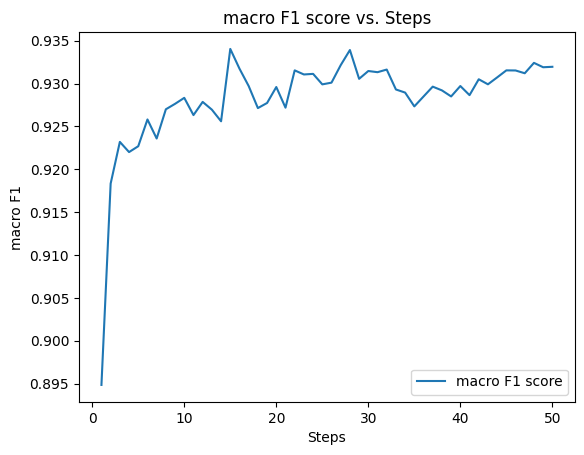

In [69]:
#plot the macro f1 over epoches
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments

# Define your Trainer and TrainingArguments
# Start training
# Extract training and validation loss from the log history

# train_losses = [0.0162, 0.0111, 0.0547, 0.0033, 0.0024]
# eval_losses = [item['eval_loss'] for item in trainer.state.log_history]
# Plot training and validation loss
# print(epoches)
plt.plot(epochF1, macroF1, label='macro F1 score')
# plt.plot(eval_losses, label='Testing loss')
#plt.title('Training and Testing Loss vs. Steps')
plt.title('macro F1 score vs. Steps')

plt.xlabel('Steps')
plt.ylabel('macro F1')
plt.legend()
plt.show()


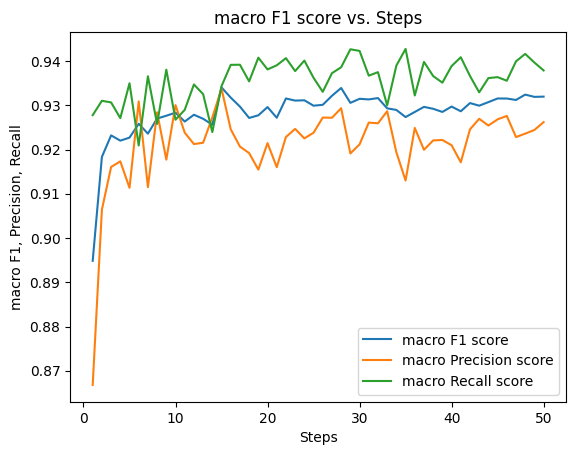

In [76]:
#plot the macro f1, precision, recall over epoches
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments

# Define your Trainer and TrainingArguments
# Start training
# Extract training and validation loss from the log history

# train_losses = [0.0162, 0.0111, 0.0547, 0.0033, 0.0024]
# eval_losses = [item['eval_loss'] for item in trainer.state.log_history]
# Plot training and validation loss
# print(epoches)
plt.plot(epochF1, macroF1, label='macro F1 score')
plt.plot(epochF1, macroPrecision, label='macro Precision score')
plt.plot(epochF1, macroRecall, label='macro Recall score')

# plt.plot(eval_losses, label='Testing loss')
#plt.title('Training and Testing Loss vs. Steps')
plt.title('macro F1 score vs. Steps')

plt.xlabel('Steps')
plt.ylabel('macro F1, Precision, Recall')
plt.legend()
plt.show()

[0.0, 0.01, 0.01, 0.02, 0.02, 0.03, 0.03, 0.04, 0.04, 0.05, 0.05, 0.06, 0.06, 0.07, 0.07, 0.07, 0.08, 0.08, 0.09, 0.09, 0.1, 0.1, 0.11, 0.11, 0.12, 0.12, 0.13, 0.13, 0.14, 0.14, 0.14, 0.15, 0.15, 0.16, 0.16, 0.17, 0.17, 0.18, 0.18, 0.19, 0.19, 0.2, 0.2, 0.21, 0.21, 0.21, 0.22, 0.22, 0.23, 0.23, 0.24, 0.24, 0.25, 0.25, 0.26, 0.26, 0.27, 0.27, 0.28, 0.28, 0.29, 0.29, 0.29, 0.3, 0.3, 0.31, 0.31, 0.32, 0.32, 0.33, 0.33, 0.34, 0.34, 0.35, 0.35, 0.36, 0.36, 0.36, 0.37, 0.37, 0.38, 0.38, 0.39, 0.39, 0.4, 0.4, 0.41, 0.41, 0.42, 0.42, 0.43, 0.43, 0.43, 0.44, 0.44, 0.45, 0.45, 0.46, 0.46, 0.47, 0.47, 0.48, 0.48, 0.49, 0.49, 0.5, 0.5, 0.5, 0.51, 0.51, 0.52, 0.52, 0.53, 0.53, 0.54, 0.54, 0.55, 0.55, 0.56, 0.56, 0.57, 0.57, 0.57, 0.58, 0.58, 0.59, 0.59, 0.6, 0.6, 0.61, 0.61, 0.62, 0.62, 0.63, 0.63, 0.64, 0.64, 0.64, 0.65, 0.65, 0.66, 0.66, 0.67, 0.67, 0.68, 0.68, 0.69, 0.69, 0.7, 0.7, 0.71, 0.71, 0.71, 0.72, 0.72, 0.73, 0.73, 0.74, 0.74, 0.75, 0.75, 0.76, 0.76, 0.77, 0.77, 0.78, 0.78, 0.79, 0.79, 0

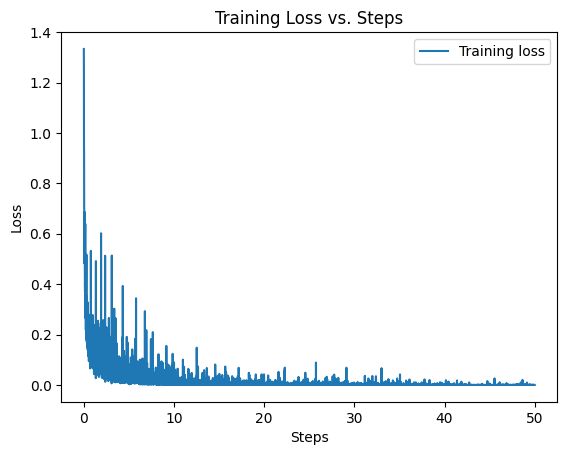

In [67]:
#plot the training loss
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments

# Define your Trainer and TrainingArguments
# Start training
# Extract training and validation loss from the log history

# train_losses = [0.0162, 0.0111, 0.0547, 0.0033, 0.0024]
# eval_losses = [item['eval_loss'] for item in trainer.state.log_history]
x = [1,2,3,4,5]
# Plot training and validation loss
print(epoches)
plt.plot(epoches, train_loss, label='Training loss')
# plt.plot(eval_losses, label='Testing loss')
#plt.title('Training and Testing Loss vs. Steps')
plt.title('Training Loss vs. Steps')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()


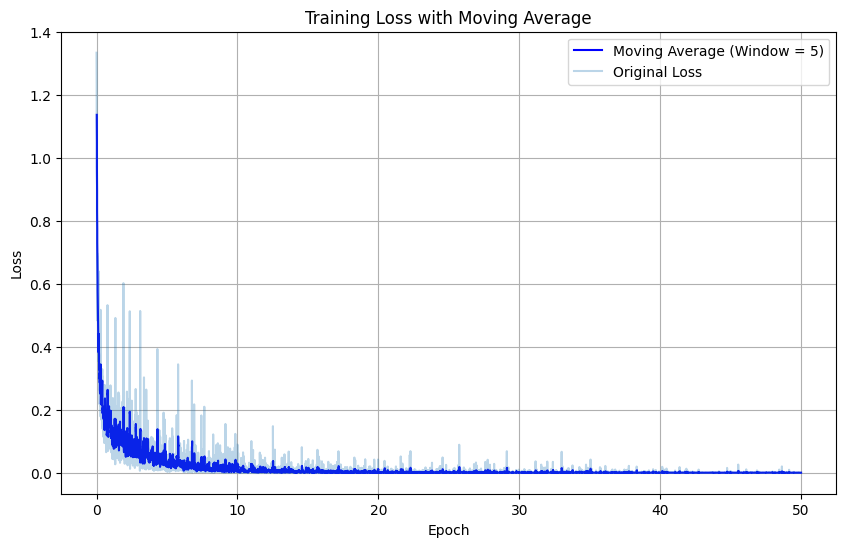

In [73]:
#plot the training loss in moving average
import matplotlib.pyplot as plt
from transformers import Trainer, TrainingArguments

# Define your Trainer and TrainingArguments
# Start training
# Extract training and validation loss from the log history
#plot epoches, train_loss
window_size = 5
moving_average = np.convolve(train_loss, np.ones(window_size)/window_size, mode='valid')

# Plot original loss and moving average
plt.figure(figsize=(10, 6))
plt.plot(epoches[window_size - 1:], moving_average, label=f'Moving Average (Window = {window_size})',color = 'blue')
plt.plot(epoches, train_loss, alpha=0.3, label='Original Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss with Moving Average')
plt.legend()
plt.grid(True)
plt.show()

In [77]:
from sklearn.metrics import precision_score, recall_score, f1_score,accuracy_score, classification_report

predictions, labels, _ = trainer.predict(labeled_dataset["test"])
# print(predictions)
#neural network output classification
predictions = np.argmax(predictions, axis=2)
# print(predictions)

# Remove ignored index (special tokens)
true_predictions = [
    [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
# print(true_predictions)

true_labels = [
    [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
print("number of text in prediction:",len(true_predictions))
# print(len(true_labels))
print("predict labels",true_predictions)
print("true labels",true_labels)
# results = metric.compute(predictions=true_predictions, references=true_labels)
# print(results)

flat_y_true = [item for sublist in true_labels for item in sublist]
flat_y_pred = [item for sublist in true_predictions for item in sublist]
print("totoal number of labels in prediction:",len(flat_y_true))


precision = precision_score(flat_y_true, flat_y_pred, average='macro')
recall = recall_score(flat_y_true, flat_y_pred, average='macro')
f1 = f1_score(flat_y_true, flat_y_pred, average='macro')
accuracy = accuracy_score(flat_y_true, flat_y_pred)

print("Macro Precision:", precision)
print("Macro Recall:", recall)
print("Macro F1 Score:", f1)
print("Accuracy:", accuracy)

report = classification_report(flat_y_true, flat_y_pred, output_dict=True)

report



number of text in prediction: 855
predict labels [['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'B-AE', 'I-AE', 'I-AE', 'I-AE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'B-AE', 'I-AE', 'I-AE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'I-AE', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-AE', 'I-AE', 'O', 'B-AE', 'I-AE', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-AE', 'I-AE', 'I-AE', 'I-AE', 'O', 'O', 'O'

{'B-AE': {'precision': 0.8736492103075644,
  'recall': 0.8982905982905983,
  'f1-score': 0.8857985672144963,
  'support': 1170},
 'I-AE': {'precision': 0.9209138840070299,
  'recall': 0.936550491510277,
  'f1-score': 0.9286663712893222,
  'support': 4476},
 'O': {'precision': 0.9840360413300034,
  'recall': 0.9788114953726255,
  'f1-score': 0.9814168152181876,
  'support': 20530},
 'accuracy': 0.9679859413202934,
 'macro avg': {'precision': 0.9261997118815325,
  'recall': 0.9378841950578337,
  'f1-score': 0.9319605845740021,
  'support': 26176},
 'weighted avg': {'precision': 0.9683083759696014,
  'recall': 0.9679859413202934,
  'f1-score': 0.9681227925565923,
  'support': 26176}}

In [78]:
#use the table to show the evaluation result
eval_test_result = pd.DataFrame(report).transpose()

eval_test_result

,precision,recall,f1-score,support
B-AE,0.873649,0.898291,0.885799,1170.000000
I-AE,0.920914,0.936550,0.928666,4476.000000
O,0.984036,0.978811,0.981417,20530.000000
accuracy,0.967986,0.967986,0.967986,0.967986
macro avg,0.926200,0.937884,0.931961,26176.000000
weighted avg,0.968308,0.967986,0.968123,26176.000000


In [79]:
#show dimensions
num_rows = len(true_predictions)
# Assuming each inner list can have a different length
num_cols_per_row = [len(row) for row in true_predictions]

print("Number of rows for predictions:", num_rows)
print("Number of columns in each row:", num_cols_per_row)


Number of rows for predictions: 855
Number of columns in each row: [38, 26, 15, 46, 24, 28, 28, 23, 16, 28, 23, 31, 37, 31, 51, 27, 53, 39, 23, 25, 28, 12, 23, 29, 23, 27, 31, 27, 16, 16, 37, 44, 27, 29, 29, 18, 35, 55, 20, 32, 53, 29, 23, 45, 21, 15, 27, 40, 22, 19, 51, 35, 84, 44, 14, 30, 15, 30, 28, 15, 29, 54, 25, 28, 36, 19, 19, 49, 40, 30, 46, 24, 32, 34, 31, 34, 24, 106, 13, 26, 12, 30, 26, 31, 27, 34, 20, 17, 50, 28, 23, 14, 28, 59, 27, 30, 60, 49, 18, 31, 13, 18, 41, 40, 64, 33, 45, 56, 19, 25, 22, 19, 22, 26, 62, 26, 26, 29, 45, 40, 40, 60, 17, 16, 29, 22, 22, 18, 15, 33, 45, 23, 29, 39, 47, 42, 23, 34, 46, 33, 27, 19, 39, 85, 42, 22, 26, 17, 44, 46, 19, 28, 29, 15, 13, 38, 18, 23, 47, 29, 64, 20, 37, 27, 50, 49, 23, 8, 38, 35, 44, 15, 47, 48, 30, 45, 47, 32, 25, 14, 18, 15, 48, 21, 40, 34, 17, 17, 44, 10, 24, 79, 30, 39, 41, 43, 51, 39, 21, 31, 24, 15, 21, 18, 22, 28, 12, 45, 22, 40, 23, 34, 14, 34, 49, 43, 15, 21, 28, 19, 15, 27, 42, 33, 30, 46, 40, 33, 19, 31, 27, 16, 13, 

In [80]:
report

{'B-AE': {'precision': 0.8736492103075644,
  'recall': 0.8982905982905983,
  'f1-score': 0.8857985672144963,
  'support': 1170},
 'I-AE': {'precision': 0.9209138840070299,
  'recall': 0.936550491510277,
  'f1-score': 0.9286663712893222,
  'support': 4476},
 'O': {'precision': 0.9840360413300034,
  'recall': 0.9788114953726255,
  'f1-score': 0.9814168152181876,
  'support': 20530},
 'accuracy': 0.9679859413202934,
 'macro avg': {'precision': 0.9261997118815325,
  'recall': 0.9378841950578337,
  'f1-score': 0.9319605845740021,
  'support': 26176},
 'weighted avg': {'precision': 0.9683083759696014,
  'recall': 0.9679859413202934,
  'f1-score': 0.9681227925565923,
  'support': 26176}}

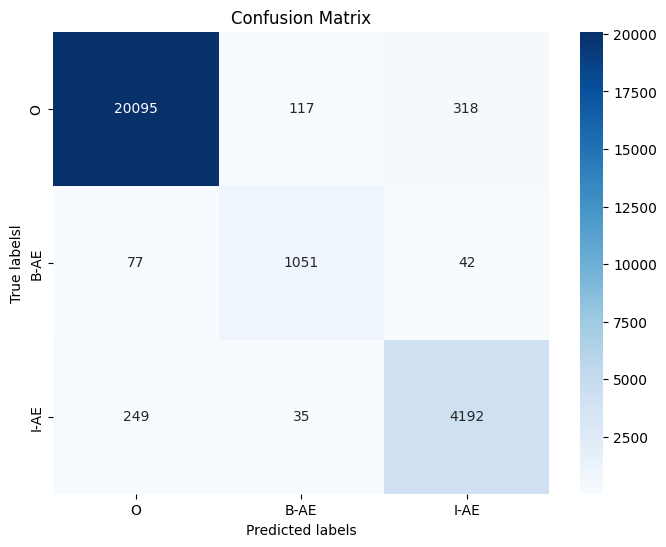

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Sample data
#flat_y_pred
#flat_y_true
label_list = ['O', 'B-AE', 'I-AE']

# Compute the confusion matrix
cm = confusion_matrix(flat_y_true, flat_y_pred, labels = label_list)

# Compute classification report
report = classification_report(flat_y_true, flat_y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

# Plotting
plt.figure(figsize=(8,6))

# Confusion matrix heatmap
# sns.heatmap(cm, annot=True, fmt='g', ax=ax[0], cmap='Blues')

sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',xticklabels=label_list, yticklabels=label_list)
plt.ylabel('True labelsl')
plt.xlabel('Predicted labels')
plt.title('Confusion Matrix')
plt.show()


# # Bar chart for precision, recall, f1-score
# df_report[:-3].plot(kind='bar', y=['precision', 'recall', 'f1-score'], ax=ax[1])
# ax[1].set_title('Precision, Recall & F1 Score per Class')
# ax[1].set_ylabel('Score')
# ax[1].set_ylim([0, 1.1])
# plt.tight_layout()



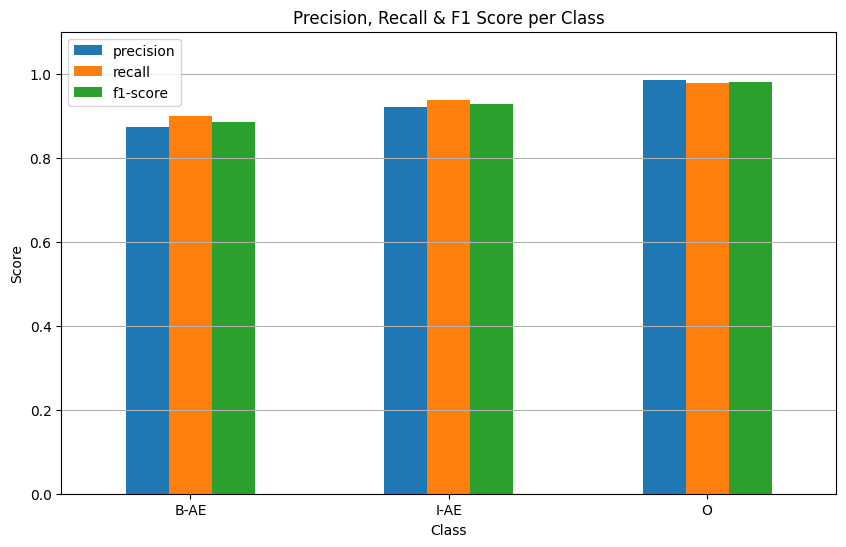

In [82]:
df_report = df_report[['precision', 'recall', 'f1-score']][:-3]

# Plot
df_report.plot(kind='bar', figsize=(10,6))
plt.title('Precision, Recall & F1 Score per Class')
plt.ylabel('Score')
plt.xlabel('Class')
plt.ylim(0, 1.1)
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

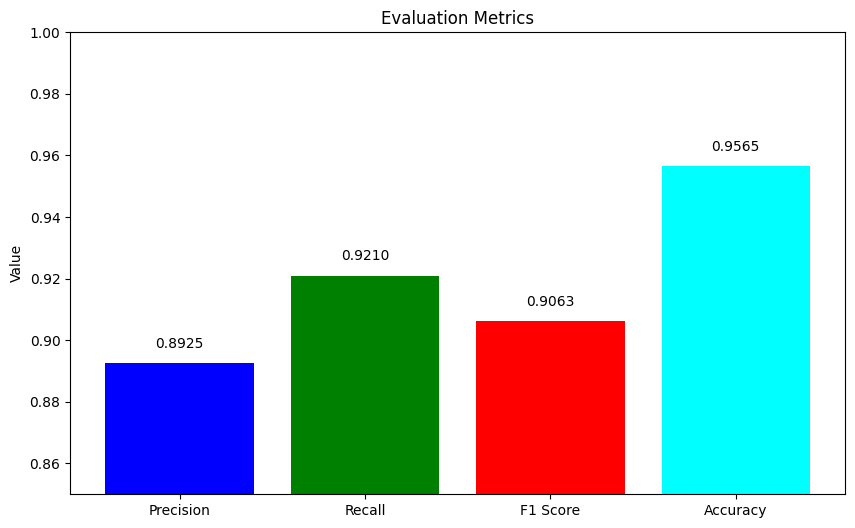

In [83]:
import matplotlib.pyplot as plt
metrics = {
    'Precision': 0.8925347342363213,
    'Recall': 0.9210316002318214,
    'F1 Score': 0.9062853884410021,
    'Accuracy': 0.9564994405072734
}
# Plotting
names = list(metrics.keys())
values = list(metrics.values())

plt.figure(figsize=(10, 6))
plt.bar(names, values, color=['blue', 'green', 'red', 'cyan'])
plt.ylim(0.85, 1)  # Setting y-axis limits to better visualize differences
plt.ylabel('Value')
plt.title('Evaluation Metrics')
for i, v in enumerate(values):
    plt.text(i, v + 0.005, "{:.4f}".format(v), ha='center')  # Displaying the metric values on the bars

plt.show()

In [84]:

import os
from google.colab import drive

drive.mount('/content/drive')

save_dir = '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/'

# model.save_pretrained("general_ner_model")


model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)


Mounted at /content/drive


('/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/tokenizer_config.json',
 '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/special_tokens_map.json',
 '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/vocab.txt',
 '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/added_tokens.json',
 '/content/drive/My Drive/Bert_model/ADE_Corpus_V2/model/tokenizer.json')

In [89]:
effect_ner_model = pipeline(task="ner", model=model, tokenizer=tokenizer)


In [91]:
effect_ner_model("I feel like a zombie after taking advil")


RuntimeError: ignored